# Linear regression in depth

*Fraida Fund*

In [1]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

# for 3d interactive plots
from ipywidgets import interact, fixed, widgets
from mpl_toolkits import mplot3d

## Data generated by a linear function

Suppose we have a process that generates data as

$$y_i = w_0 + w_1 x_{i,1} + \ldots + w_d x_{i,d} + \epsilon_i $$

where $\epsilon_i \sim N(0, \sigma^2)$.

Note: in this example, we use a “stochastic error” term. This is not to be confused with a residual term which can include systematic, non-random error.

-   stochastic error: difference between observed value and “true” value. These random errors are independent, not systematic, and cannot be “learned” by any machine learning model.
-   residual: difference between observed value and estimated value. These errors are typical *not* independent, and they can be systematic.

Here’s a function to generate this kind of data

In [2]:
def generate_linear_regression_data(n=100, d=1, coef=[5], intercept=1, sigma=0):
  x = np.random.randn(n,d)
  y = (np.dot(x, coef) + intercept).squeeze() + sigma * np.random.randn(n)
  return x, y

and some default values we’ll use:

In [3]:
n_samples = 100
coef = [5]
intercept = 1

## Simple linear regression

### Generate some data

In [4]:
x_train, y_train = generate_linear_regression_data(n=n_samples, d=1, coef=coef, intercept=intercept)
x_test,  y_test  = generate_linear_regression_data(n=50, d=1, coef=coef, intercept=intercept)

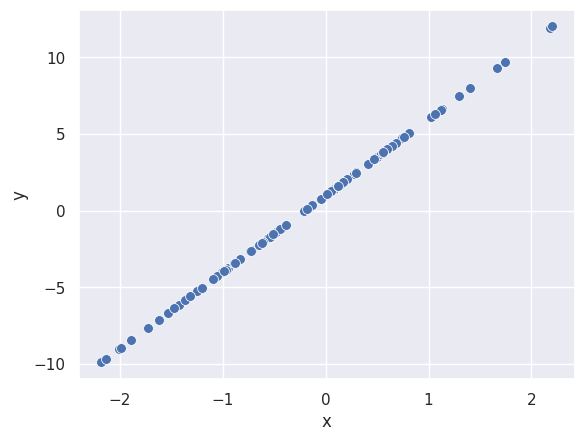

In [5]:
sns.scatterplot(x=x_train.squeeze(), y=y_train, s=50);
plt.xlabel('x');
plt.ylabel('y');

Note: we generated `x` as a 2D array with `n_samples` rows and 1 column, but to plot it we need a 1D array. In our “crash course” lecture, we introduced the `squeeze()` function that removes any dimension with size 1, so the result here is a 1D array. We could also have used `x_train.reshape(-1,)`.

### Fit a linear regression

In the “classical machine learning” part of this course, we’ll use `scikit-learn` implementations of most ML models. These all follow the same standard format, so once you learn how to use one, you know the basic usage of all of them.

The basic format is:

``` python
m = Model()        # create an instance of the model - whatever type it is
m.fit(x_tr, y_tr)  # fit the model using the training data. Note: x_tr must be 2D
                   # if x_tr is 1D, make it 2D by passing x_tr.reshape((-1,1)) or x_tr[:,None]

y_tr_hat = m.predict(x_tr)  # now get model prediction on training data (note: x_tr still must be 2D!)
y_ts_hat = m.predict(x_ts)  # also get model prediction on test data (note: x_ts must be 2D!)


metrics.mean_squared_error(y_ts, y_ts_hat)  # for regression: get error on the test data
metrics.r2_score(y_ts, y_ts_hat)            # or R2 on the test data
m.score(x_ts, y_ts)                         # another way to get test data performance (R2 for regression)
```

Many models have some additional arguments you can set, or parameters you can check after fitting - check the documentation for details. For example, you can review the [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model documentation.

Here’s how this would apply for a `LinearRegression()` model.

In [6]:
reg_simple = LinearRegression().fit(x_train, y_train)
print("Intercept: " , reg_simple.intercept_)
print("Coefficient list: ", reg_simple.coef_)

Intercept:  0.9999999999999998
Coefficient list:  [5.]


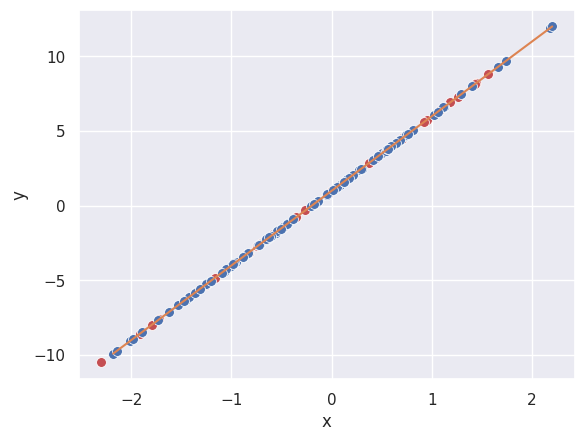

In [7]:
x_line = [np.min(x_train), np.max(x_train)]
y_line = x_line*reg_simple.coef_ + reg_simple.intercept_
sns.scatterplot(x=x_test.squeeze(), y=y_test, s=50, color=sns.color_palette()[3]);
sns.scatterplot(x=x_train.squeeze(), y=y_train, s=50);
sns.lineplot(x=x_line, y=y_line, color=sns.color_palette()[1]);
plt.xlabel('x');
plt.ylabel('y');

In [8]:
# Note: other ways to do the same thing...
# first, add a ones column to design matrix
x_tilde = np.hstack((np.ones((n_samples, 1)), x_train))

# using matrix operations to find w = (X^T X)^{-1} X^T y
print( (np.linalg.inv((x_tilde.T @ x_tilde)) @ x_tilde.T @ y_train) )

# using solve on normal equations: X^T X w = X^T y
# solve only works on matrix that is square and of full-rank
# see https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html
print( np.linalg.solve(x_tilde.T @ x_tilde, x_tilde.T @ y_train) )

# using the lstsq solver
# problem may be under-, well-, or over-determined
# see https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html
print( np.linalg.lstsq(x_tilde,y_train,rcond=0)[0] )

[1. 5.]
[1. 5.]
[1. 5.]


### The mean-removed equivalent

Quick digression - what if we don’t want to bother with intercept?

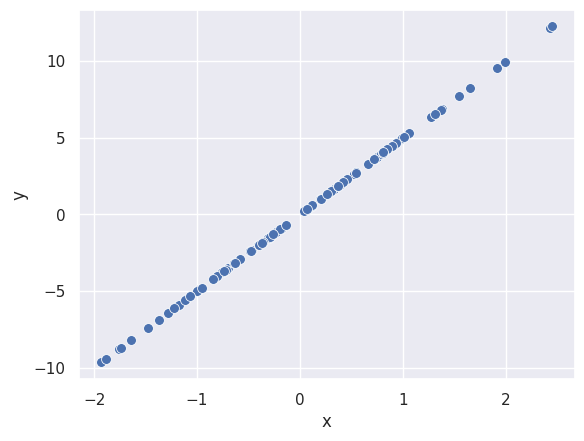

In [9]:
x_train_mr = x_train - np.mean(x_train)
y_train_mr = y_train - np.mean(y_train)
sns.scatterplot(x=x_train_mr.squeeze(), y=y_train_mr, s=50);
plt.xlabel('x');
plt.ylabel('y');

Note that now the data is mean removed - zero mean in every dimension. (Removing the mean is also called *centering* the data.)

This time, the fitted linear regression has 0 intercept:

(We could have specified `fit_intercept=False` as an argument to the model, but we didn’t so that we could see for ourselves that the intercept is zero!)

In [10]:
reg_mr = LinearRegression().fit(x_train_mr, y_train_mr)
print("Intercept: " , reg_mr.intercept_)
print("Coefficient list: ", reg_mr.coef_)

Intercept:  2.1760371282653065e-16
Coefficient list:  [5.]


Important: when pre-processing data (for example, scaling, or removing the mean), we will always use the training data *only* to get the pre-processing parameters. For example, to get the mean-removed test data we would use

``` python
x_test_mr = x_test - np.mean(x_train)
y_test_mr = y_test - np.mean(y_train)
```

### Predict some new points

OK, now we can predict some new points:

In [11]:
y_test_hat = reg_simple.predict(x_test)

In [12]:
x_line = [np.min(x_test), np.max(x_test)]
y_line = x_line*reg_simple.coef_ + reg_simple.intercept_

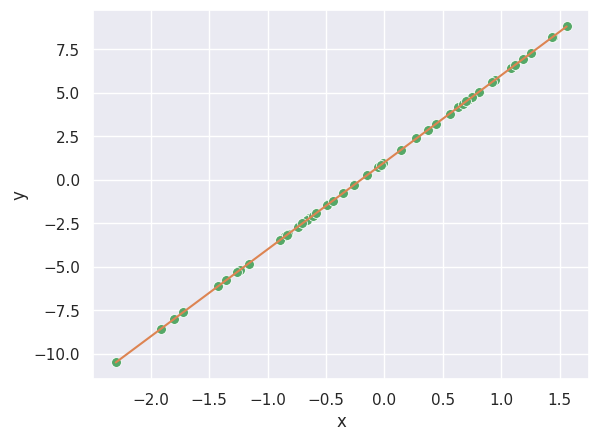

In [13]:
sns.lineplot(x=x_line, y=y_line, color=sns.color_palette()[1]);
sns.scatterplot(x=x_test.squeeze(), y=y_test_hat, s=50, color=sns.color_palette()[2]);
plt.xlabel('x');
plt.ylabel('y');

### Compute MSE

To evaluate the model, we will compute the MSE on the test data (*not* the data used to find the parameters).

$$MSE = \frac{1}{n} \sum_{i=1}^n (y_i - (w_0 + w_1 x_i)) ^2$$

Use $\hat{y}_i = w_0 + w_1 x_i$, then

$$MSE = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i) ^2$$

Here’s the `numpy` way:

In [14]:
y_test_hat = reg_simple.intercept_ + np.dot(x_test,reg_simple.coef_)
mse_simple = 1.0/(len(y_test)) * np.sum((y_test - y_test_hat)**2)
mse_simple

7.790001439057492e-32

Here’s the `scikit-learn` way:

In [15]:
# another way to do the same thing using sklearn
y_test_hat = reg_simple.predict(x_test)
metrics.mean_squared_error(y_test, y_test_hat)

7.790001439057492e-32

### Visualize MSE for different coefficients

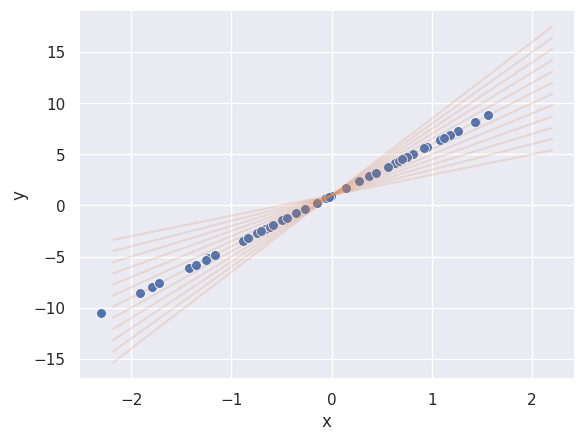

In [16]:
coefs = np.arange(2, 8, 0.5)

x_line_c = np.array([np.min(x_train), np.max(x_train)])
y_line_c = coefs.reshape(-1,1)*x_line_c.reshape(1,-1) + reg_simple.intercept_

p = sns.scatterplot(x=x_test.squeeze(), y=y_test_hat, s=50);
p = plt.xlabel('x')
p = plt.ylabel('y')
for idx, c in enumerate(coefs):
  p = sns.lineplot(x=x_line_c, y=y_line_c[idx], color=sns.color_palette()[1], alpha=0.2);

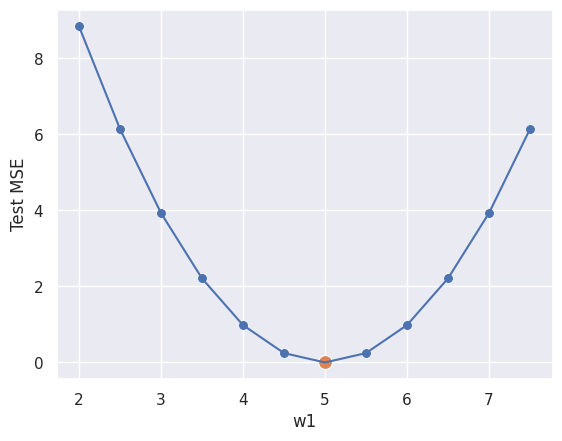

In [17]:
y_test_hat_c = coefs.reshape(-1,1)*x_test.reshape(1,-1) + reg_simple.intercept_
mses_c = 1.0/(len(y_test)) * np.sum((y_test - y_test_hat_c)**2, axis=1)

sns.lineplot(x=coefs, y=mses_c);
sns.scatterplot(x=coefs, y=mses_c, s=50);
sns.scatterplot(x=reg_simple.coef_, y=mse_simple, color=sns.color_palette()[1], s=100);
p = plt.xlabel('w1');
p = plt.ylabel('Test MSE');

### Variance, explained variance, R2

Quick reminder:

Mean of $x$ and $y$:

$$\bar{x} = \frac{1}{n} \sum_{i=1}^n x_i, \quad \bar{y} = \frac{1}{n} \sum_{i=1}^n y_i$$

Variance of $x$ and $y$:

$$\sigma_x^2 = \frac{1}{n} \sum_{i=1}^n (x_i - \bar{x}) ^2, \quad \sigma_y^2 = \frac{1}{n} \sum_{i=1}^n (y_i - \bar{y}) ^2$$

Covariance of $x$ and $y$:

$$\sigma_{xy} = \frac{1}{n} \sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})$$

In [18]:
var_y = 1.0/len(y_test) * np.sum((y_test - np.mean(y_test))**2) # or use np.var()
var_y

23.84235266419949

In [19]:
mean_y = np.mean(y_test)
mean_y

0.16476848571335181

The variance of $y$ is the mean sum of the squares of the distances from each $y_i$ to $\bar{y}$. These distances are illustrated here:

-   the horizontal line shows $\bar{y}$
-   each vertical line is a distance from a $y_i$ to $\bar{y}$

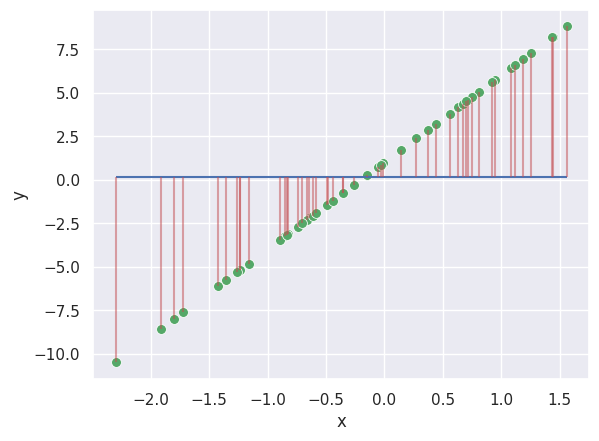

In [20]:
plt.hlines(y=mean_y, xmin=np.min(x_test), xmax=np.max(x_test));
plt.vlines(x_test, ymin=mean_y, ymax=y_test, alpha=0.5, color=sns.color_palette()[3]);
sns.scatterplot(x=x_test.squeeze(), y=y_test, color=sns.color_palette()[2], s=50);
plt.xlabel('x');
plt.ylabel('y');

Now let’s look at a similar kind of plot, but with distances to the regression line instead of the to mean line:

-   In the previous plot, each vertical line was a $y_i - \bar{y}$
-   In the following plot, each vertical line is a $y_i - \hat{y}_i$

(where $\hat{y}_i$ is the prediction of the linear regression for a given sample $i$)

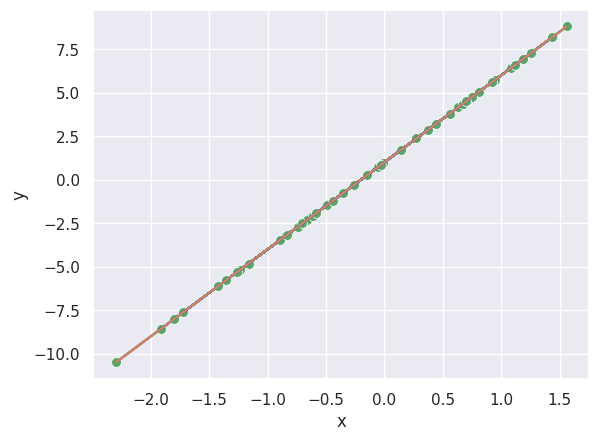

In [21]:
plt.plot(x_test, y_test_hat);
plt.vlines(x_test, ymin=y_test, ymax=y_test_hat, color=sns.color_palette()[3], alpha=0.5);
sns.scatterplot(x=x_test.squeeze(), y=y_test, color=sns.color_palette()[2], s=50);
x_line = [np.min(x_test), np.max(x_test)]
y_line = x_line*reg_simple.coef_ + reg_simple.intercept_
sns.lineplot(x=x_line, y=y_line, color=sns.color_palette()[1]);
plt.xlabel('x');
plt.ylabel('y');

These two plots together show how well the variance of $y$ is “explained” by the linear regression model:

-   The total variance of $y$ is shown in the first plot, where each vertical line is

$$y_i - \bar{y}$$

-   The *unexplained* variance of $y$ is shown in the second plot, where each vertical line is the error of the model,

$$y_i - \hat{y}_i$$

In this example, *all* of the variance of $y$ is “explained” by the linear regression.

MSE for this example is 0, R2 is 1.

In [22]:
@interact(intercept_fit = widgets.FloatSlider(min=-8, max=8, step=0.5, value=1),
   coef_fit = widgets.FloatSlider(min=-8, max=8, step=0.1, value=5),
   show_residual=True)
def plot_reg(intercept_fit, coef_fit, show_residual):
    x_train, y_train = generate_linear_regression_data(n=20000, d=1, coef=5, intercept=1, sigma=0)
    x_test,  y_test =  generate_linear_regression_data(n=10000, d=1, coef=5, intercept=1, sigma=0)
    y_test_hat = intercept_fit + coef_fit*x_test
    r2_test = metrics.r2_score(y_test, y_test_hat)
    mse_test = metrics.mean_squared_error(y_test, y_test_hat)
    x_line = np.array([-3, 3])
    y_line = intercept_fit + coef_fit*x_line
    plt.axhline(y=np.mean(y_train), color=sns.color_palette()[1]);
    if show_residual:
      plt.vlines(x_test[:100,], ymin=y_test[:100,], ymax=y_test_hat[:100,], alpha=0.5, color=sns.color_palette()[3]);
    sns.lineplot(x=x_line, y=y_line, color=sns.color_palette()[2]);
    sns.scatterplot(x=x_test[:100,].squeeze(), y=y_test[:100], s=50);
    plt.xlabel('x');
    plt.ylabel('y');
    plt.ylim(-20,20)
    plt.xlim(-3,3)
    plt.title("MSE: %f\nR2: %f" % (mse_test, r2_test) )
    plt.show()


interactive(children=(FloatSlider(value=1.0, description='intercept_fit', max=8.0, min=-8.0, step=0.5), FloatS…

## Simple linear regression with noise

### Generate some data

In [23]:
x_train, y_train = generate_linear_regression_data(n=n_samples, d=1, coef=coef, intercept=intercept, sigma=2)
x_test,  y_test =  generate_linear_regression_data(n=50, d=1, coef=coef, intercept=intercept, sigma=2)

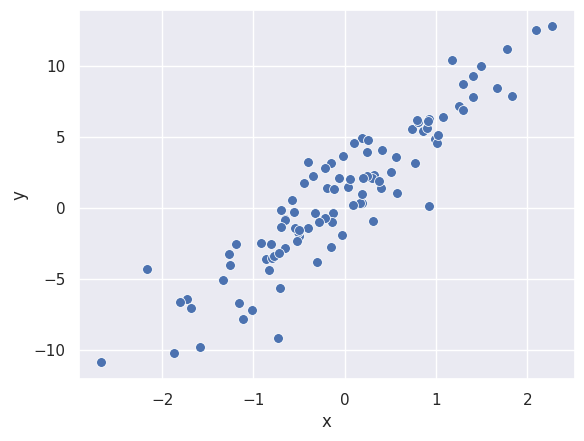

In [24]:
sns.scatterplot(x=x_train.squeeze(), y=y_train, s=50);
plt.xlabel('x');
plt.ylabel('y');

### Fit a linear regression

In [25]:
reg_noisy = LinearRegression().fit(x_train, y_train)
print("Coefficient list: ", reg_noisy.coef_)
print("Intercept: " , reg_noisy.intercept_)

Coefficient list:  [4.85681318]
Intercept:  1.0688908488214381


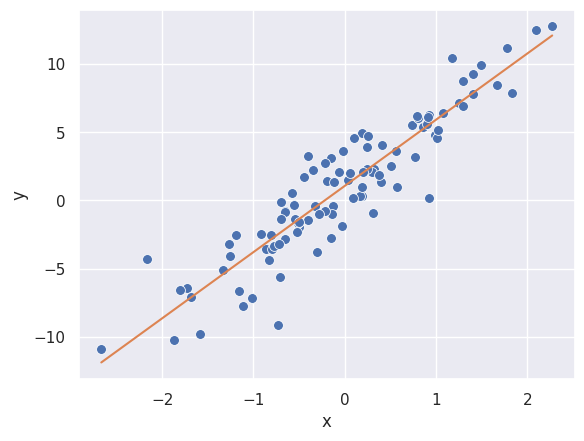

In [26]:
x_line = [np.min(x_train), np.max(x_train)]
y_line = x_line*reg_noisy.coef_ + reg_noisy.intercept_

sns.scatterplot(x=x_train.squeeze(), y=y_train, s=50);
sns.lineplot(x=x_line, y=y_line, color=sns.color_palette()[1]);
plt.xlabel('x');
plt.ylabel('y');


### Predict some new points

In [27]:
y_test_hat = reg_noisy.intercept_ + np.dot(x_test,reg_noisy.coef_)

In [28]:
x_line = [np.min(x_test), np.max(x_test)]
y_line = x_line*reg_noisy.coef_ + reg_noisy.intercept_

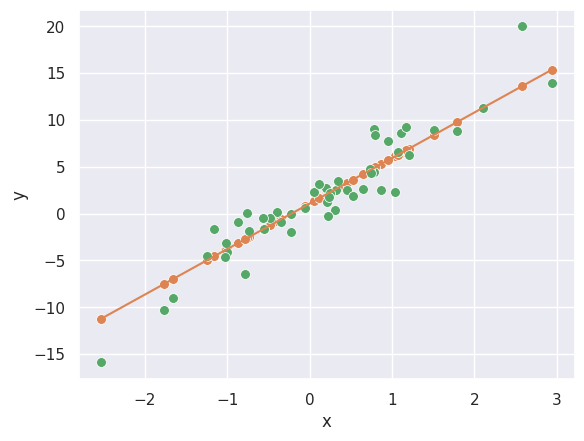

In [29]:
sns.lineplot(x=x_line, y=y_line, color=sns.color_palette()[1]);
sns.scatterplot(x=x_test.squeeze(), y=y_test_hat, color=sns.color_palette()[1], s=50);
sns.scatterplot(x=x_test.squeeze(), y=y_test, color=sns.color_palette()[2], s=50);
plt.xlabel('x');
plt.ylabel('y');


### Compute MSE

In [30]:
y_test_hat = reg_noisy.intercept_ + np.dot(x_test,reg_noisy.coef_)
mse_noisy = 1.0/(len(y_test)) * np.sum((y_test - y_test_hat)**2)
mse_noisy

4.1970434394458636

The MSE is higher than before! (When it was essentially zero.)

Does this mean our estimate of $w_0$ and $w_1$ is not optimal?

Since we generated the data, we know the “true” coefficient value and we can see how much the MSE would be with the true coefficient values.

In [31]:
y_test_perfect_coef = intercept + np.dot(x_test,coef)

mse_perfect_coef = 1.0/(len(y_test_perfect_coef)) * np.sum((y_test_perfect_coef - y_test)**2)
mse_perfect_coef

4.065002984195834

Sometimes our linear regression doesn’t select the “true” coefficients?

In [32]:
y_train_hat = reg_noisy.intercept_ + np.dot(x_train,reg_noisy.coef_)
mse_train_est = 1.0/(len(y_train)) * np.sum((y_train - y_train_hat)**2)
mse_train_est

3.8283738307020156

In [33]:
y_train_perfect_coef = intercept + np.dot(x_train,coef)
mse_train_perfect = 1.0/(len(y_train_perfect_coef)) * np.sum((y_train_perfect_coef - y_train)**2)
mse_train_perfect

3.8528594006050714

The “correct” coefficients had slightly higher MSE on the training set than the fitted coefficients. We fit parameters so that they are optimal on the *training* set, then we use the test set to understand how the model will generalize to new, unseen data.

We saw that part of the MSE is due to noise in the data, and part is due to error in the parameter estimates.

Soon - we will formalize this discussion of different sources of error:

-   Error in parameter estimates
-   “Noise” - any variation in data that is not a function of the $X$ that we use as input to the model
-   Other error - for example, model (hypothesis class) not a good choice for the data

### Visualize MSE for different coefficients

In [34]:
coefs = np.arange(4.5, 5.5, 0.1)

y_test_hat_c = reg_noisy.intercept_ + np.dot(x_test,coefs.reshape(1,-1))
mses_test =  np.mean((y_test.reshape(-1,1) - y_test_hat_c)**2, axis=0)
y_train_hat_c = reg_noisy.intercept_ + np.dot(x_train,coefs.reshape(1,-1))
mses_train =  np.mean((y_train.reshape(-1,1) - y_train_hat_c)**2, axis=0)

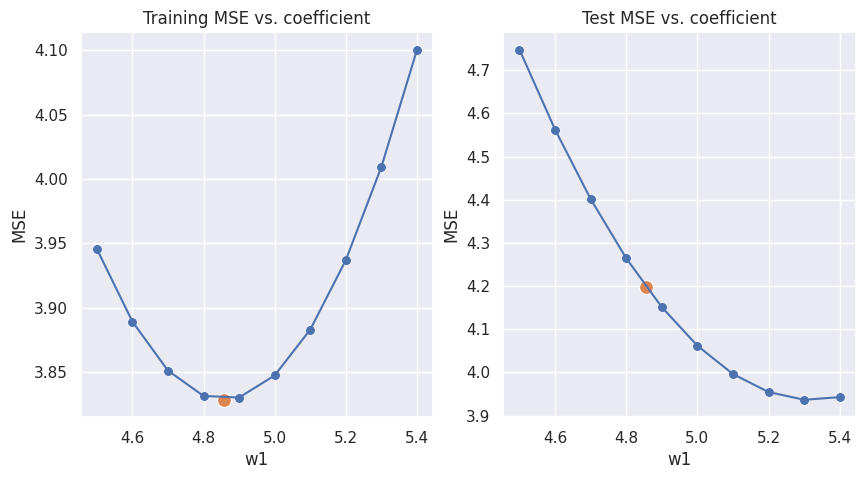

In [35]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.lineplot(x=coefs, y=mses_train)
sns.scatterplot(x=coefs, y=mses_train, s=50);
sns.scatterplot(x=reg_noisy.coef_, y=mse_train_est, color=sns.color_palette()[1], s=100);
plt.title("Training MSE vs. coefficient");
plt.xlabel('w1');
plt.ylabel('MSE');

plt.subplot(1,2,2)
sns.lineplot(x=coefs, y=mses_test)
sns.scatterplot(x=coefs, y=mses_test, s=50);
sns.scatterplot(x=reg_noisy.coef_, y=mse_noisy, color=sns.color_palette()[1], s=100);
plt.title("Test MSE vs. coefficient");
plt.xlabel('w1');
plt.ylabel('MSE');

In the plot on the left (for training MSE), the orange dot (our coefficient estimate) should always have minimum MSE, because we select parameters to minimize MSE on the training set.

In the plot on the right (for test MSE), the orange dot might not have the minimum MSE, because the best coefficient on the training set might not be the best coefficient on the test set. This gives us some idea of how our model will generalize to new, unseen data. We may suspect that if the coefficient estimate is not perfect for *this* test data, it might have some error on other new, unseen data, too.

If you re-run this notebook many times, you’ll get a new random sample of training and test data each time. Sometimes, the “true” coefficients may have smaller MSE on the test set than the estimated coefficients. On other runs, the estimated coefficients might have smaller MSE on the test set.

### Variance, explained variance, R2

In [36]:
var_y = 1.0/len(y_test) * np.sum((y_test - np.mean(y_test))**2)
var_y

37.02206248039319

In [37]:
mean_y = np.mean(y_test)
mean_y

1.9286087070074813

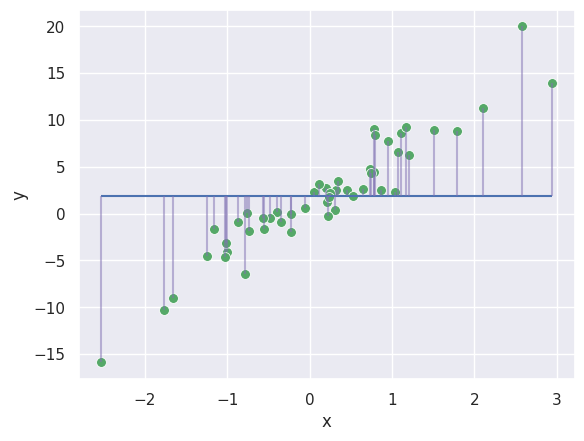

In [38]:
x_line = [np.min(x_test), np.max(x_test)]
y_line = x_line*reg_noisy.coef_ + reg_noisy.intercept_
plt.hlines(mean_y, xmin=np.min(x_test), xmax=np.max(x_test));
plt.vlines(x_test, ymin=mean_y, ymax=y_test, color=sns.color_palette()[4], alpha=0.5);
sns.scatterplot(x=x_test.squeeze(), y=y_test, color=sns.color_palette()[2], s=50);
plt.xlabel('x');
plt.ylabel('y');

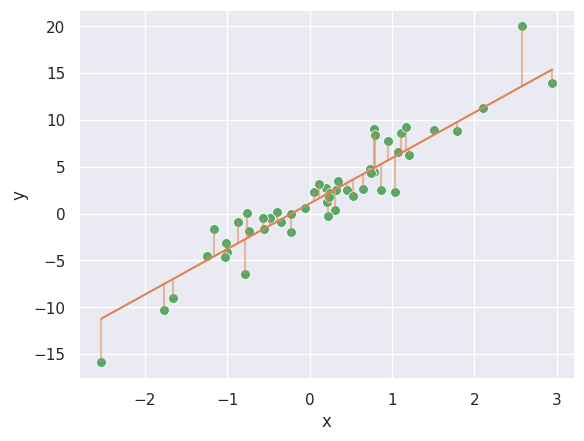

In [39]:
plt.vlines(x_test, ymin=y_test, ymax=y_test_hat, color=sns.color_palette()[1], alpha=0.5);
sns.scatterplot(x=x_test.squeeze(), y=y_test, color=sns.color_palette()[2], s=50);
x_line = [np.min(x_test), np.max(x_test)]
y_line = x_line*reg_noisy.coef_ + reg_noisy.intercept_
sns.lineplot(x=x_line, y=y_line, color=sns.color_palette()[1]);
plt.xlabel('x');
plt.ylabel('y');

Remember:

The total variance of $y$ is shown in the first plot, where each vertical line is $y_i - \bar{y}$

The *unexplained* variance of $y$ is shown in the second plot, where each vertical line is the error of the model, $y_i - \hat{y}_i$

In the next plot, we’ll combine them to get some intuition regarding the *fraction of unexplained variance*. The purple part of each vertical bar is the *unexplained* part, while the orange part is *explained* by the linear regression.

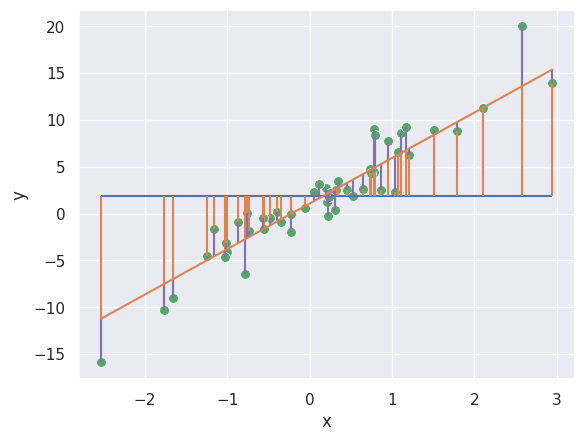

In [40]:

x_line = [np.min(x_test), np.max(x_test)]
y_line = x_line*reg_noisy.coef_ + reg_noisy.intercept_

plt.hlines(mean_y, xmin=np.min(x_test), xmax=np.max(x_test));
plt.vlines(x_test, ymin=mean_y, ymax=y_test, color=sns.color_palette()[1]);
plt.vlines(x_test, ymin=y_test, ymax=y_test_hat, color=sns.color_palette()[4]);
sns.scatterplot(x=x_test.squeeze(), y=y_test, color=sns.color_palette()[2], s=50);
sns.lineplot(x=x_line, y=y_line, color=sns.color_palette()[1]);
plt.xlabel('x');
plt.ylabel('y');

**Fraction of variance unexplained** is the ratio of the sum of squared distances from data to the regression line (sum of squared vertical distances in second plot), to the sum of squared distanced from data to the mean (sum of squared vertical distances in first plot):

$$\frac{MSE}{Var(y)} = \frac{Var(y-\hat{y})}{Var(y)} = \frac{\sum_{i=1}^n(y_i-\hat y_i)^2}{\sum_{i=1}^n(y_i - \bar{y})^2}$$

Alternative interpretation: imagine we would develop a very simple ML model, in which we always predict $\hat{y}_i = \bar{y}_i$. Then, we use this model as a basis for comparison for other, more sophisticated models. The ratio above is the ratio of error of the regression model, to the error of a “prediction by mean” model.

-   If this quantity is less than 1, our model is better than “prediction by mean”
-   If this quantity is greater than 1, our model is worse than “prediction by mean”

In [41]:
fvu = mse_noisy/var_y
fvu

0.11336600821925061

In [42]:
r2 = 1 - fvu
r2

0.8866339917807494

In [43]:
# another way to do the same thing...
metrics.r2_score(y_test, y_test_hat)

0.8866339917807494

What does a negative R2 mean, in terms of a comparison to “prediction by mean”?

### More on coefficient value, metrics

In [44]:
@interact(sigma = widgets.IntSlider(min=0, max=5, step=1, value=2),
   coef = widgets.IntSlider(min=-5, max=5, step=1, value=2))
def plot_reg(sigma, coef):
    x_train, y_train = generate_linear_regression_data(n=20000, d=1, coef=coef, intercept=intercept, sigma=sigma)
    x_test,  y_test =  generate_linear_regression_data(n=10000, d=1, coef=coef, intercept=intercept, sigma=sigma)
    r_mod = LinearRegression().fit(x_train, y_train)
    r2_test = r_mod.score(x_test, y_test)
    mse_test = metrics.mean_squared_error(y_test, r_mod.predict(x_test))
    x_line = np.array([-3, 3])
    y_line = r_mod.predict(x_line.reshape(-1,1))
    plt.axhline(y=np.mean(y_train), color=sns.color_palette()[1]);
    sns.lineplot(x=x_line, y=y_line, color=sns.color_palette()[2]);
    sns.scatterplot(x=x_test[:100,].squeeze(), y=y_test[:100], s=50);
    plt.xlabel('x');
    plt.ylabel('y');
    plt.ylim(-20,20)
    plt.xlim(-3,3)
    plt.title("MSE: %f\nR2: %f" % (mse_test, r2_test) )
    plt.show()

interactive(children=(IntSlider(value=2, description='sigma', max=5), IntSlider(value=2, description='coef', m…

Remember that in this data, the *only* source of error is the $\epsilon$ in

$$y_i = w_0 + w_1 x_{i,1} + \ldots + w_d x_{i,d} + \epsilon_i $$

where $\epsilon_i \sim N(0, \sigma^2)$. If not for this, our regression would fit the data perfectly.

Interpreting the coefficient:

> An increase in $x$ of 1 is, on average, associated with an increase in $y$ of about $w_1$.

Note that it does not imply any causal relationship!

Interpreting MSE and R2:

-   MSE shows us the variance of the data around the regression line (for data with this specific type of “noise”).
-   MSE is a measure of the model error, not relative to any baseline. We can use it to compare different models on the same dataset (but not on different datasets).
-   R2 tells us what fraction of the variance in the data is “explained” by the regression line.
-   R2 is a measure relative to the “prediction by mean” baseline. (Note that if “prediction by mean” is already good, even a well fitting regression line will not have a high R2.)
-   Prediction by mean is the same thing as prediction by a line with

$$w_0 = \overline{y}, w_1 = 0$$

-   The greater the true $w_1$, the more “wrong” the $w_1 = 0$ “prediction” is.

## Residual analysis

In [45]:
df = sns.load_dataset("anscombe")
df.groupby('dataset').agg({'x': ['count','mean', 'std'], 'y': ['count','mean', 'std']})

x                    y                    
        count mean       std count      mean       std
dataset                                               
I          11  9.0  3.316625    11  7.500909  2.031568
II         11  9.0  3.316625    11  7.500909  2.031657
III        11  9.0  3.316625    11  7.500000  2.030424
IV         11  9.0  3.316625    11  7.500909  2.030579

In [46]:
data_i   = df[df['dataset'].eq('I')]
data_ii  = df[df['dataset'].eq('II')]
data_iii = df[df['dataset'].eq('III')]
data_iv  = df[df['dataset'].eq('IV')]

In [47]:
reg_i   = LinearRegression().fit(data_i[['x']],   data_i['y'])
reg_ii  = LinearRegression().fit(data_ii[['x']],  data_ii['y'])
reg_iii = LinearRegression().fit(data_iii[['x']], data_iii['y'])
reg_iv  = LinearRegression().fit(data_iv[['x']],  data_iv['y'])

In [48]:
print("Dataset I:   ",   reg_i.coef_,   reg_i.intercept_)
print("Dataset II:  ",  reg_ii.coef_,  reg_ii.intercept_)
print("Dataset III: ", reg_iii.coef_, reg_iii.intercept_)
print("Dataset IV:  ",  reg_iv.coef_,  reg_iv.intercept_)

Dataset I:    [0.50009091] 3.0000909090909094
Dataset II:   [0.5] 3.00090909090909
Dataset III:  [0.49972727] 3.002454545454545
Dataset IV:   [0.49990909] 3.0017272727272726


In [49]:
print("Dataset I:   ", metrics.r2_score(data_i['y'],  reg_i.predict(data_i[['x']])))
print("Dataset II:  ", metrics.r2_score(data_ii['y'], reg_ii.predict(data_ii[['x']])))
print("Dataset III: ", metrics.r2_score(data_iii['y'],reg_iii.predict(data_iii[['x']])))
print("Dataset IV:  ", metrics.r2_score(data_iv['y'], reg_iv.predict(data_iv[['x']])))

Dataset I:    0.6665424595087748
Dataset II:   0.6662420337274844
Dataset III:  0.6663240410665592
Dataset IV:   0.6667072568984653


In [50]:
print("Dataset I:   ", metrics.mean_squared_error(data_i['y'],  reg_i.predict(data_i[['x']])))
print("Dataset II:  ", metrics.mean_squared_error(data_ii['y'], reg_ii.predict(data_ii[['x']])))
print("Dataset III: ", metrics.mean_squared_error(data_iii['y'],reg_iii.predict(data_iii[['x']])))
print("Dataset IV:  ", metrics.mean_squared_error(data_iv['y'], reg_iv.predict(data_iv[['x']])))

Dataset I:    1.2511536363636366
Dataset II:   1.2523900826446281
Dataset III:  1.2505628925619836
Dataset IV:   1.249317272727273


All of these models are equally “good” according to our scoring metrics… BUT

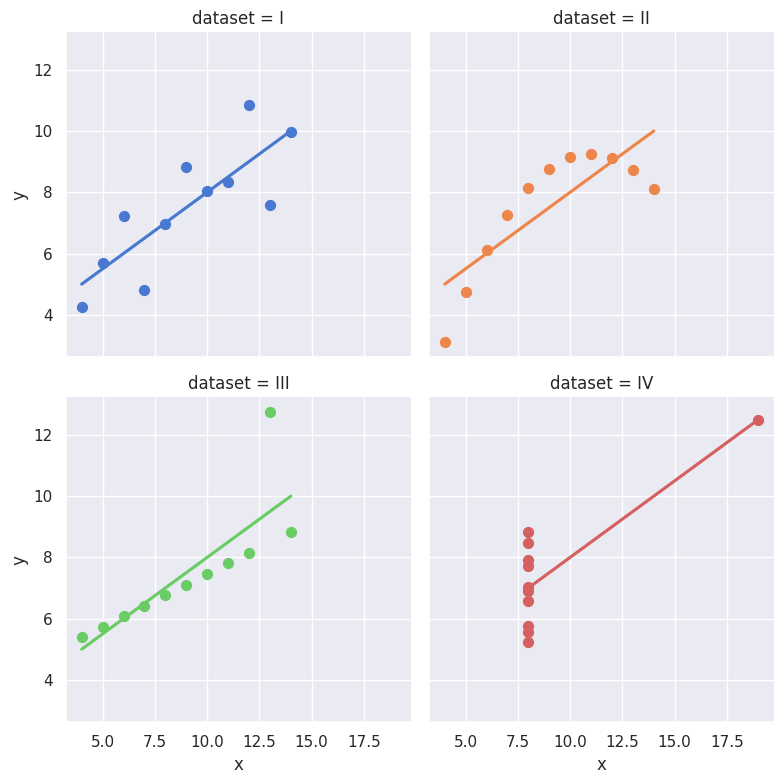

In [51]:
sns.lmplot(x="x", y="y", col="dataset", hue="dataset",
           data=df, col_wrap=2, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1});

Does the linear model fit well?

-   the linear model is a good fit for Dataset I
-   Dataset II is clearly non-linear
-   Dataset III has an outlier
-   Dataset IV has a high leverage point

Easy to identify problems in 1D - what about in higher D?

-   Plot $\hat{y}$ against $y$
-   Plot residuals against $\hat{y}$
-   Plot residuals against each $x$ (including any $x$ not in the model)
-   Plot residuals against time (for time series data)

What should each of these plots look like if the regression is “good”?

In [52]:
data_i   = data_i.assign(   yhat = reg_i.predict(  data_i[['x']]) )
data_ii  = data_ii.assign(  yhat = reg_ii.predict( data_ii[['x']]) )
data_iii = data_iii.assign( yhat = reg_iii.predict( data_iii[['x']]) )
data_iv  = data_iv.assign(  yhat = reg_iv.predict(  data_iv[['x']]) )

data_i   = data_i.assign(   residual = data_i['y'] - data_i['yhat'] )
data_ii  = data_ii.assign(  residual = data_ii['y'] - data_ii['yhat'] )
data_iii = data_iii.assign( residual = data_iii['y'] - data_iii['yhat'] )
data_iv  = data_iv.assign(  residual = data_iv['y'] - data_iv['yhat'] )

data_all = pd.concat([data_i, data_ii, data_iii, data_iv])
data_all.head()

,dataset,x,y,yhat,residual
0,I,10.0,8.04,8.001000,0.039000
1,I,8.0,6.95,7.000818,-0.050818
2,I,13.0,7.58,9.501273,-1.921273
3,I,9.0,8.81,7.500909,1.309091
4,I,11.0,8.33,8.501091,-0.171091


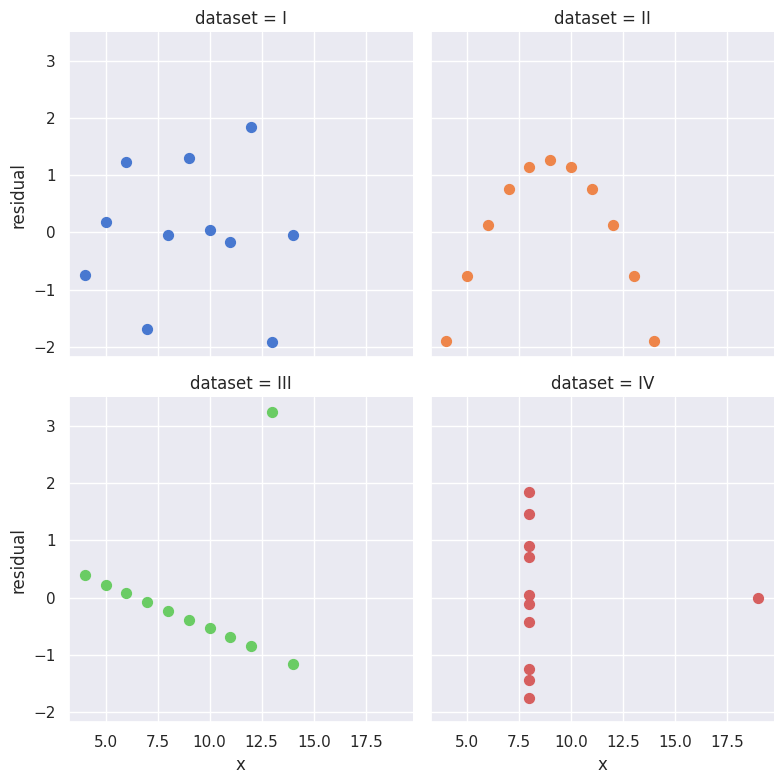

In [53]:
sns.lmplot(x="x", y="residual", col="dataset", hue="dataset",
           data=data_all, col_wrap=2, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1}, fit_reg=False);

## Multiple linear regression

### Generate some data

In [54]:
x_train, y_train = generate_linear_regression_data(n=n_samples, d=2, coef=[5,5], intercept=intercept)
x_test,  y_test  = generate_linear_regression_data(n=50, d=2, coef=[5,5], intercept=intercept)


In [55]:
x_train.shape

(100, 2)

In [56]:
y_train.shape

(100,)

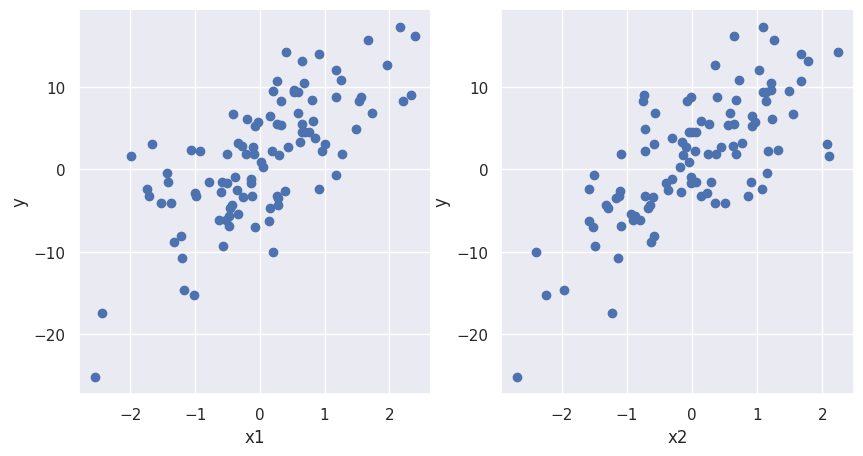

In [57]:
plt.figure(figsize=(10,5));
plt.subplot(1,2,1);
plt.scatter(x_train[:,0],  y_train);
plt.xlabel("x1");
plt.ylabel("y");
plt.subplot(1,2,2);
plt.scatter(x_train[:,1],  y_train);
plt.xlabel("x2");
plt.ylabel("y");

Recall that there is no stochastic noise in this data - so it fits a linear model perfectly. But it’s more difficult to see that linear relationship in higher dimensions.

### Fit a linear regression

In [58]:
reg_multi = LinearRegression().fit(x_train, y_train)
print("Coefficient list: ", reg_multi.coef_)
print("Intercept: " , reg_multi.intercept_)

Coefficient list:  [5. 5.]
Intercept:  0.9999999999999998


### Plot hyperplane

In [59]:
def plot_3D(elev=20, azim=-20, X=x_train, y=y_train):
    plt.figure(figsize=(10,10))
    ax = plt.subplot(projection='3d')


    X1 = np.arange(-4, 4, 0.2)
    X2 = np.arange(-4, 4, 0.2)
    X1, X2 = np.meshgrid(X1, X2)
    Z = X1*reg_multi.coef_[0] + X2*reg_multi.coef_[1]

    # Plot the surface.
    ax.plot_surface(X1, X2, Z, alpha=0.1, color='gray',
                          linewidth=0, antialiased=False)
    ax.scatter3D(X[:, 0], X[:, 1], y, s=50)

    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('y')
    plt.show()

interact(plot_3D, elev=widgets.IntSlider(min=-90, max=90, step=10, value=20),
          azim=widgets.IntSlider(min=-90, max=90, step=10, value=20),
         X=fixed(x_train), y=fixed(y_train));

interactive(children=(IntSlider(value=20, description='elev', max=90, min=-90, step=10), IntSlider(value=20, d…

### MSE contour

In [60]:
coefs = np.arange(3.0, 7.0, 0.05)

coef_grid = np.array(np.meshgrid(coefs, coefs)).reshape(1, 2, coefs.shape[0], coefs.shape[0])
y_train_hat_c = (reg_multi.intercept_ + np.sum(coef_grid * x_train.reshape(x_train.shape[0], 2, 1, 1), axis=1) )
mses_train = np.mean((y_train_hat_c- y_train.reshape(-1, 1, 1))**2, axis=0)

<ipython-input-61-e2d8446c3cde>:2: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  p = plt.scatter(x=reg_multi.coef_[0], y=reg_multi.coef_[1], c=sns.color_palette()[1])


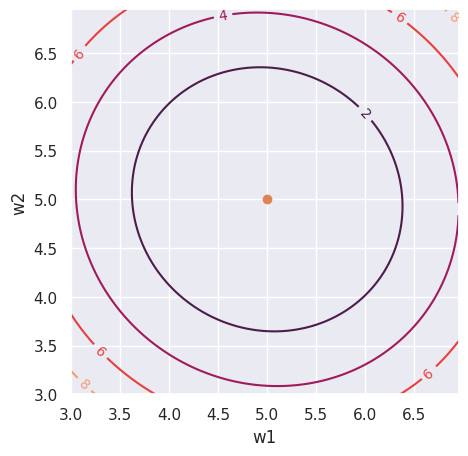

In [61]:
plt.figure(figsize=(5,5));
p = plt.scatter(x=reg_multi.coef_[0], y=reg_multi.coef_[1], c=sns.color_palette()[1])
p = plt.contour(coef_grid[0, 0, :, :], coef_grid[0, 1, :, :], mses_train, levels=5);
plt.clabel(p, inline=1, fontsize=10);
plt.xlabel('w1');
plt.ylabel('w2');

In [62]:
coefs = np.arange(3.0, 7.0, 0.05)

coef_grid = np.array(np.meshgrid(coefs, coefs)).reshape(1, 2, coefs.shape[0], coefs.shape[0])
y_test_hat_c = (reg_multi.intercept_ + np.sum(coef_grid * x_test.reshape(x_test.shape[0], 2, 1, 1), axis=1) )
mses_test = np.mean((y_test_hat_c- y_test.reshape(-1, 1, 1))**2, axis=0)

<ipython-input-63-2c93fc2de86d>:2: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  p = plt.scatter(x=reg_multi.coef_[0], y=reg_multi.coef_[1], c=sns.color_palette()[1])


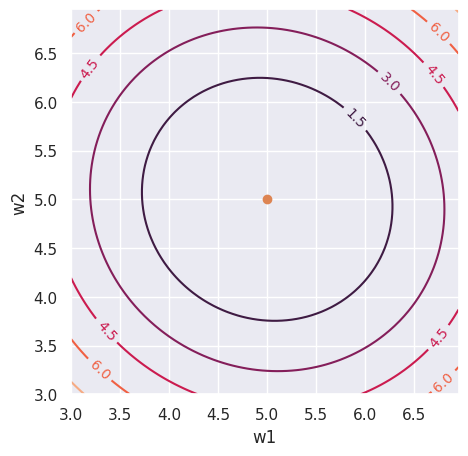

In [63]:
plt.figure(figsize=(5,5));
p = plt.scatter(x=reg_multi.coef_[0], y=reg_multi.coef_[1], c=sns.color_palette()[1])
p = plt.contour(coef_grid[0, 0, :, :], coef_grid[0, 1, :, :], mses_test, levels=5);
plt.clabel(p, inline=1, fontsize=10);
plt.xlabel('w1');
plt.ylabel('w2');

## Multiple linear regression with noise

### Generate some data

In [64]:
x_train, y_train = generate_linear_regression_data(n=n_samples, d=2, coef=[5,5], intercept=intercept, sigma=5)
x_test,  y_test  = generate_linear_regression_data(n=50, d=2, coef=[5,5], intercept=intercept, sigma=5)

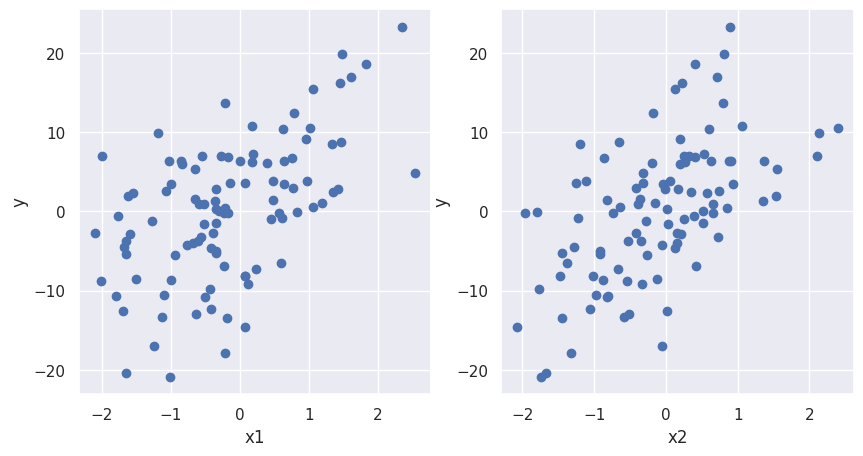

In [65]:
plt.figure(figsize=(10,5));
plt.subplot(1,2,1);
plt.scatter(x_train[:,0],  y_train);
plt.xlabel("x1");
plt.ylabel("y");
plt.subplot(1,2,2);
plt.scatter(x_train[:,1],  y_train);
plt.xlabel("x2");
plt.ylabel("y");

### Fit a linear regression

In [66]:
reg_multi_noisy = LinearRegression().fit(x_train, y_train)
print("Coefficient list: ", reg_multi_noisy.coef_)
print("Intercept: " , reg_multi_noisy.intercept_)

Coefficient list:  [4.83295471 5.60916385]
Intercept:  1.659039625901277


### Plot hyperplane

In [67]:
def plot_3D(elev=20, azim=-20, X=x_train, y=y_train):
    plt.figure(figsize=(10,10))
    ax = plt.subplot(projection='3d')


    X1 = np.arange(-4, 4, 0.2)
    X2 = np.arange(-4, 4, 0.2)
    X1, X2 = np.meshgrid(X1, X2)
    Z = X1*reg_multi_noisy.coef_[0] + X2*reg_multi_noisy.coef_[1]

    # Plot the surface.
    ax.plot_surface(X1, X2, Z, alpha=0.1, color='gray',
                          linewidth=0, antialiased=False)
    ax.scatter3D(X[:, 0], X[:, 1], y, s=50)

    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('y')
    plt.show()

interact(plot_3D, elev=widgets.IntSlider(min=-90, max=90, step=10, value=20),
          azim=widgets.IntSlider(min=-90, max=90, step=10, value=20),
         X=fixed(x_train), y=fixed(y_train));

interactive(children=(IntSlider(value=20, description='elev', max=90, min=-90, step=10), IntSlider(value=20, d…

### MSE contour

In [68]:
coefs = np.arange(3.0, 7.0, 0.05)

coef_grid = np.array(np.meshgrid(coefs, coefs)).reshape(1, 2, coefs.shape[0], coefs.shape[0])
y_train_hat_c = (reg_multi_noisy.intercept_ + np.sum(coef_grid * x_train.reshape(x_train.shape[0], 2, 1, 1), axis=1) )
mses_train = np.mean((y_train_hat_c- y_train.reshape(-1, 1, 1))**2, axis=0)

<ipython-input-69-52cd0b4ff0f1>:2: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  p = plt.scatter(x=reg_multi_noisy.coef_[0], y=reg_multi_noisy.coef_[1], c=sns.color_palette()[1])


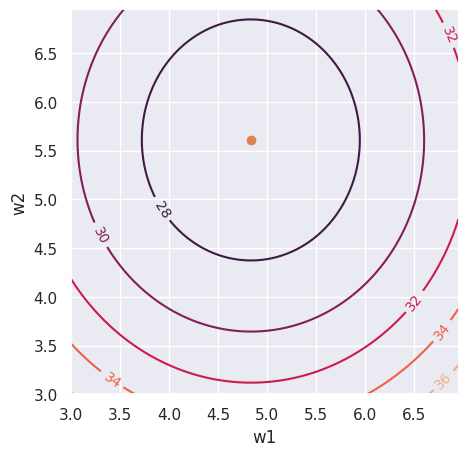

In [69]:
plt.figure(figsize=(5,5));
p = plt.scatter(x=reg_multi_noisy.coef_[0], y=reg_multi_noisy.coef_[1], c=sns.color_palette()[1])
p = plt.contour(coef_grid[0, 0, :, :], coef_grid[0, 1, :, :], mses_train, levels=5);
plt.clabel(p, inline=1, fontsize=10);
plt.xlabel('w1');
plt.ylabel('w2');

In [70]:
coefs = np.arange(3.0, 7.0, 0.05)

coef_grid = np.array(np.meshgrid(coefs, coefs)).reshape(1, 2, coefs.shape[0], coefs.shape[0])
y_test_hat_c = (reg_multi_noisy.intercept_ + np.sum(coef_grid * x_test.reshape(x_test.shape[0], 2, 1, 1), axis=1) )
mses_test = np.mean((y_test_hat_c- y_test.reshape(-1, 1, 1))**2, axis=0)

<ipython-input-71-a06412f15400>:2: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  p = plt.scatter(x=reg_multi_noisy.coef_[0], y=reg_multi_noisy.coef_[1], c=sns.color_palette()[1])


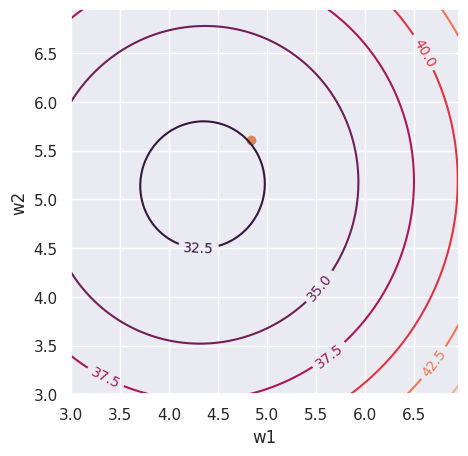

In [71]:
plt.figure(figsize=(5,5));
p = plt.scatter(x=reg_multi_noisy.coef_[0], y=reg_multi_noisy.coef_[1], c=sns.color_palette()[1])
p = plt.contour(coef_grid[0, 0, :, :], coef_grid[0, 1, :, :], mses_test, levels=5);
plt.clabel(p, inline=1, fontsize=10);
plt.xlabel('w1');
plt.ylabel('w2');

## Linear basis function regression

The assumptions of the linear model (that the target variable can be predicted as a linear combination of the features) can be restrictive. We can capture more complicated relationships using linear basis function regression.

Fundamental idea: with a set of “basis” functions, we represent the “shape” of our data as a weighted sum of basis functions:

$$ \hat{y_i} =  \sum_{j=0}^p w_p \phi_p(\mathbf{x_i}) $$

(We’ll revisit this idea again later in the semester, when we talk about kernels; and again, when we talk about activation functions in neural networks.)

We’re going to look at some examples of basis functions (but not an exhaustive list…)

(Note: it’s also possible to mix-and-match basis functions from different “families” in the same model! And, you can apply basis functions to multiple features, too.)

### Linear basis

Transform a feature $x$ using $\phi_0(x) = 1, \phi_1(x) = x$, i.e.

$$y \approx w_0 + w_1 x $$

In [72]:
def linear_basis(x):
  return np.hstack([np.ones(x.shape),x])

x = np.arange(-1.5,1.5,step=0.01).reshape(-1,1)
x_trans = linear_basis(x)

@interact(w0 = widgets.FloatSlider(min=-2, max=2, step=0.1, value=1),
          w1 = widgets.FloatSlider(min=-2, max=2, step=0.1, value=1),
          show_sum = False)
def plot_linear(w0, w1, show_sum):
  plt.figure(figsize=(10,5));
  w = np.array([w0, w1])
  l = ['1', 'x']
  y = np.sum(w*x_trans, axis=1)
  if show_sum:
    sns.lineplot(x=x.squeeze(), y=y, label='sum', alpha=1, lw=2);
  for i in range(2):
    sns.lineplot(x=x.squeeze(), y=w[i]*x_trans[:,i], label='$' + l[i] + '$', alpha=0.5);
  plt.ylim(-2, 2);
  plt.title("Linear basis");
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0);
  plt.xlabel('x')
  plt.ylabel('$\phi(x)$')
  plt.show()

interactive(children=(FloatSlider(value=1.0, description='w0', max=2.0, min=-2.0), FloatSlider(value=1.0, desc…

### Polynomial basis

Transform a feature $x$ using $\phi_j(x) = x^j$, i.e.

$$y \approx w_0 x^0 + w_1 x^1 + \ldots + w_p x^p $$

Note that the model is linear in the parameters $\mathbf{w}$, which is what makes it a linear model even though it is not linear in $x$.

In [73]:
def polynomial_basis(x, d):
  return x**np.arange(d)

x = np.arange(-1.5,1.5,step=0.01).reshape(-1,1)
x_trans = polynomial_basis(x,5)

@interact(w0 = widgets.FloatSlider(min=-1, max=2, step=0.1, value=1),
          w1 = widgets.FloatSlider(min=-1, max=2, step=0.1, value=1),
          w2 = widgets.FloatSlider(min=-1, max=2, step=0.1, value=1),
          w3 = widgets.FloatSlider(min=-1, max=2, step=0.1, value=1),
          w4 = widgets.FloatSlider(min=-1, max=2, step=0.1, value=1),
          show_sum = False)
def plot_poly(w0, w1, w2, w3, w4, show_sum):
  plt.figure(figsize=(10,5));
  w = np.array([w0, w1, w2, w3, w4])
  y = np.sum(w*x_trans, axis=1)
  if show_sum:
    sns.lineplot(x=x.squeeze(), y=y, label='sum', alpha=1, lw=2);
  for i in range(5):
    sns.lineplot(x=x.squeeze(), y=w[i]*x_trans[:,i], label='$x^' + str(i) + '$', alpha=0.5);
  plt.ylim(-2, 2);
  plt.title("Polynomial basis");
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0);
  plt.xlabel('x')
  plt.ylabel('$\phi(x)$')
  plt.show()

interactive(children=(FloatSlider(value=1.0, description='w0', max=2.0, min=-1.0), FloatSlider(value=1.0, desc…

In practice, polynomial functions are actually not very useful for modeling real data -

-   polynomials are “global” functions - affect the entire range from $-\infty$ to $\infty$, even though different parts of the data might have different behavior
-   they get weird at the boundaries of the data (Runge’s phenomenon) and *really* bad if you need to extrapolate past the range of the training data

Instead of high-degree polynomials, we tend to prefer lower-degree *piecewise* functions, so we can fit *local* behavior.

### Splines

With splines, the feature axis is divided into breakpoints - we call each breakpoints a “knot” - and then we define basis functions that are a polynomial function of the feature between two knots.

If we constrain the piecewise function to meet at the knots, we call these splines - basis splines or “B splines”. Here is how these functions are defined:

First, for constant functions (degree 0) - given “knots” at positions $k_t, k_{t+1}$:

$$
\phi_{t,0}({x}) =
\begin{cases}
1, \quad  k_t \leq x < k_{t+1} \\
0, \quad  \text{otherwise}
\end{cases}
$$

Then for degree $p>0$, it is defined recursively:

$$
\phi_{t, p}( x ) := \dfrac{ x - k_t }{k_{t+p} - k_t} \phi_{t,p-1}( x ) + \dfrac{k_{t+p+1} - x }{k_{t+p+1} - k_{t+1}} \phi_{t+1,p-1}( x )
$$

But, you won’t need to compute this yourself - you can use [`SplineTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.SplineTransformer.html) in `sklearn`.

In [74]:
from sklearn.preprocessing import SplineTransformer

def spline_basis(x, d):
  return np.hstack([SplineTransformer(knots='uniform', n_knots = d, degree=i, extrapolation="constant").fit_transform(x) for i in range(d)])

x = np.arange(-1.5,1.5,step=0.01).reshape(-1,1)
x_trans = spline_basis(x,3)

@interact(w00 = widgets.FloatSlider(min=-1, max=2, step=0.1, value=1),
          w10 = widgets.FloatSlider(min=-1, max=2, step=0.1, value=1),
          w01 = widgets.FloatSlider(min=-1, max=2, step=0.1, value=1),
          w11 = widgets.FloatSlider(min=-1, max=2, step=0.1, value=1),
          w21 = widgets.FloatSlider(min=-1, max=2, step=0.1, value=1),
          w02 = widgets.FloatSlider(min=-1, max=2, step=0.1, value=1),
          w12 = widgets.FloatSlider(min=-1, max=2, step=0.1, value=1),
          w22 = widgets.FloatSlider(min=-1, max=2, step=0.1, value=1),
          w32 = widgets.FloatSlider(min=-1, max=2, step=0.1, value=1),
          show_sum = False)
def plot_spline(w00, w10, w01, w11, w21, w02, w12, w22, w32, show_sum):
  plt.figure(figsize=(10,5));
  labels = np.array(["\phi_{0,0}", "\phi_{1,0}",
                     "\phi_{0,1}", "\phi_{1,1}", "\phi_{2,1}",
                     "\phi_{0,2}", "\phi_{1,2}", "\phi_{2,2}", "\phi_{3,2}"])
  w = np.array([w00, w10, w01, w11, w21, w02, w12, w22, w32])
  y = np.sum(w*x_trans, axis=1)
  if show_sum:
    sns.lineplot(x=x.squeeze(), y=y, label='sum', alpha=1, lw=2);
  for i in range(9):
    sns.lineplot(x=x.squeeze(), y=w[i]*x_trans[:,i], label='$'+labels[i]+'$', alpha=0.5);
  plt.ylim(-2, 2);
  plt.title("Spline");
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0);
  plt.xlabel('x')
  plt.ylabel('$\phi(x)$')
  plt.show()

interactive(children=(FloatSlider(value=1.0, description='w00', max=2.0, min=-1.0), FloatSlider(value=1.0, des…

### Radial basis

Transform a feature $x$ using $\phi_j(x) = \exp\left(-\frac{(x-\mu_j)^2}{s^2}\right)$, i.e.

$$y \approx w_0 \exp\left(-\frac{(x-\mu_0)^2}{s^2}\right) + w_1 \exp\left(-\frac{(x-\mu_1)^2}{s^2}\right) + \ldots + w_p \exp\left(-\frac{(x-\mu_p)^2}{s^2}\right)$$

The model is linear in the parameters $\mathbf{w}$, which is what makes it a linear model even though it is not linear in $x$. However, it is not linear in the basis function parameters $\mu_j$ or $s$! (Those basis function parameters will not be “learned” - they are fixed by you.)

Note that in contrast to the polynomials which had “global” effect, each radial basis function has “local” effect. (Think of it as a weighted sum of little “bumps”.)

In [75]:
s = 0.1
def radial_basis(x, mu_list):
  return np.exp(-1*(x-mu_list)**2/s**2)

x = np.arange(-1.5,1.5,step=0.01).reshape(-1,1)
x_trans = radial_basis(x, [-1, -0.5, 0, 0.5, 1])

@interact(w0 = widgets.FloatSlider(min=-2, max=2, step=0.1, value=1),
          w1 = widgets.FloatSlider(min=-2, max=2, step=0.1, value=1),
          w2 = widgets.FloatSlider(min=-2, max=2, step=0.1, value=1),
          w3 = widgets.FloatSlider(min=-2, max=2, step=0.1, value=1),
          w4 = widgets.FloatSlider(min=-2, max=2, step=0.1, value=1),
          show_sum = False)
def plot_radial(w0, w1, w2, w3, w4, show_sum):
  plt.figure(figsize=(10,5));
  w = np.array([w0, w1, w2, w3, w4])
  labels = ['$exp(-(x+1)^2)/(' + str(s) + '^2))$', '$exp(-(x+0.5)^2)/(' + str(s) + '^2))$',
            '$exp(-(x)^2)/(' + str(s) + '^2))$', '$exp(-(x-0.5)^2)/(' + str(s) + '^2))$',
            '$exp(-(x-1)^2)/(' + str(s) + '^2))$']
  y = np.sum(w*x_trans, axis=1)
  if show_sum:
    sns.lineplot(x=x.squeeze(), y=y, label='sum', alpha=1, lw=2);
  for i in range(5):
    sns.lineplot(x=x.squeeze(), y=w[i]*x_trans[:,i], label=labels[i], alpha=0.5);
  plt.ylim(-2, 2)
  plt.title("Radial basis");
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0);
  plt.xlabel('x')
  plt.ylabel('$\phi(x)$')
  plt.show()

interactive(children=(FloatSlider(value=1.0, description='w0', max=2.0, min=-2.0), FloatSlider(value=1.0, desc…

(try changing `s` to see its effect!)

### Sigmoidal basis

Transform a feature $x$ using $\phi_j(x) = \sigma \left( \frac{(x-\mu_j)}{s} \right)$ where $\sigma(a) = \frac{1}{1+\exp({-a})}$, i.e.

$$y \approx w_0 \sigma \left( \frac{(x-\mu_0)}{s}  \right) + w_1 \sigma \left( \frac{(x-\mu_1)}{s}  \right) + \ldots + w_p \sigma \left( \frac{(x-\mu_p)}{s}  \right)$$

(Similar to the RBF but with “steps” instead of “bumps”…)

In [76]:
s = 0.05
def sigmoid_basis(x, mu_list):
  return ((1+np.exp((-x+mu_list)/s))**-1)

x = np.arange(-1.5,1.5,step=0.01).reshape(-1,1)
x_trans = sigmoid_basis(x, [-1, -0.5, 0, 0.5, 1])

@interact(w0 = widgets.FloatSlider(min=-2, max=2, step=0.1, value=1),
          w1 = widgets.FloatSlider(min=-2, max=2, step=0.1, value=1),
          w2 = widgets.FloatSlider(min=-2, max=2, step=0.1, value=1),
          w3 = widgets.FloatSlider(min=-2, max=2, step=0.1, value=1),
          w4 = widgets.FloatSlider(min=-2, max=2, step=0.1, value=1),
          show_sum = False)
def plot_sigmoid(w0, w1, w2, w3, w4, show_sum):
  plt.figure(figsize=(10,5));
  w = np.array([w0, w1, w2, w3, w4])
  labels = ['$\sigma((x+1)/' + str(s) + ')$', '$\sigma((x+0.5)/' + str(s) + ')$',
            '$\sigma((x)/' + str(s) + ')$', '$\sigma((x-0.5)/' + str(s) + ')$',
            '$\sigma((x-1)/' + str(s) + ')$']
  y = np.sum(w*x_trans, axis=1)
  if show_sum:
    sns.lineplot(x=x.squeeze(), y=y, label='sum', alpha=1, lw=2);
  for i in range(5):
    sns.lineplot(x=x.squeeze(), y=w[i]*x_trans[:,i], label=labels[i], alpha=0.5);
  plt.ylim(-1.5, 2)
  plt.title("Sigmoidal basis");
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0);
  plt.xlabel('x')
  plt.ylabel('$\phi(x)$')
  plt.show()

interactive(children=(FloatSlider(value=1.0, description='w0', max=2.0, min=-2.0), FloatSlider(value=1.0, desc…

(try changing `s` to see its effect!)

### Fourier basis

Transform a feature $x$ using $\phi_j(x) = cos(\pi j x) + sin(\pi j x)$, i.e.

$$y \approx w_0 + w_1 \sin(\pi x) + w_2 \cos(\pi x) + w_3 \sin(\pi  2 x) + w_4 \cos(\pi  2 x) + \ldots $$

In [77]:
def fourier_basis(x, d):
  sins = np.sin(np.pi*np.arange(1,d+1)*x)
  coss = np.cos(np.pi*np.arange(1,d+1)*x)
  return np.hstack([sins, coss])

x = np.arange(-1.5,1.5,step=0.01).reshape(-1,1)
x_trans = fourier_basis(x, 2)

@interact(w1 = widgets.FloatSlider(min=-2, max=2, step=0.1, value=1),
          w2 = widgets.FloatSlider(min=-2, max=2, step=0.1, value=1),
          w3 = widgets.FloatSlider(min=-2, max=2, step=0.1, value=1),
          w4 = widgets.FloatSlider(min=-2, max=2, step=0.1, value=1),
          show_sum = False)
def plot_fourier(w1, w2, w3, w4, show_sum):
  plt.figure(figsize=(10,5));
  w = np.array([w1, w2, w3, w4])
  labels = ["sin(\pi x)", "sin(\pi 2 x)", "cos(\pi x)", "cos(\pi 2 x)"]
  y = np.sum(w*x_trans, axis=1)
  if show_sum:
    sns.lineplot(x=x.squeeze(), y=y, label='sum', alpha=1, lw=2);
  for i in range(4):
    sns.lineplot(x=x.squeeze(), y=w[i]*x_trans[:,i], label='$' + labels[i] + '$', alpha=0.5);
  plt.ylim(-1.5, 2)
  plt.title("Fourier basis");
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0);
  plt.xlabel('x')
  plt.ylabel('$\phi(x)$')
  plt.show()

interactive(children=(FloatSlider(value=1.0, description='w1', max=2.0, min=-2.0), FloatSlider(value=1.0, desc…

### Original vs transformed feature space

When we use one of these (or another function) to transform our data before fitting a linear regression model, we take a problem that is not necessarily *linear in the original feature space*, and move it to a *transformed feature space where it is linear*.

Take the following example: suppose data is generated as

$$y_i = w_0 + w_1 \log {x_i} + \epsilon_i $$

where $\epsilon_i \sim N(0, \sigma^2)$.

In [78]:
n = 200
x = np.random.uniform(0.2, 4, size=n)
y = 3*np.log(x) + 0.3 * np.random.randn(n)

We cannot get a good fit for a linear model in the original feature space:

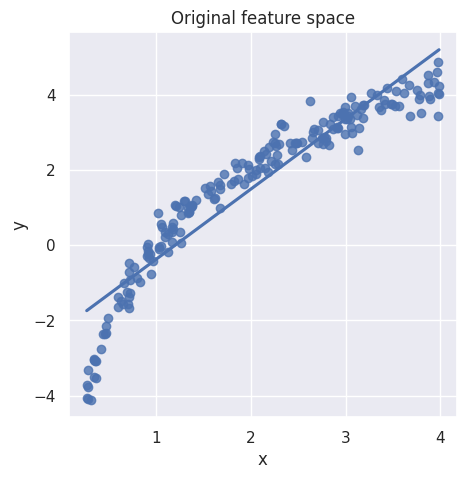

In [79]:
plt.figure(figsize=(5,5));
plt.title("Original feature space")
sns.regplot(x=x,y=y, ci=None)
plt.xlabel("x");
plt.ylabel("y");

But in the transformed feature space, where $\log (x)$ is a feature, we can get a good fit:

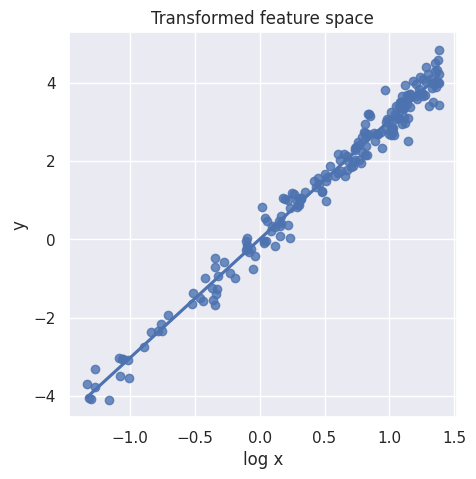

In [80]:
plt.figure(figsize=(5,5));
plt.title("Transformed feature space")
sns.regplot(x=np.log(x),y=y, ci=None)
plt.xlabel("log x");
plt.ylabel("y");

We can also visualize this process in 2D. In the following example, we have

$$y_i = w_0 + w_1 x_i + w_2 \log {x_i} + \epsilon_i $$

where $\epsilon_i \sim N(0, \sigma^2)$.

In [81]:
n = 200
x = np.random.uniform(0.2, 4, size=n)
y = -1*x + 3*np.log(x)  + 7 +  0.5 * np.random.randn(n)

In [82]:
def plot_3D(elev=20, azim=-20, X=x, y=y):
    plt.figure(figsize=(10,10))
    ax = plt.subplot(projection='3d')


    X1 = np.arange(0.2, 5, 0.2)
    X2 = np.log(np.arange(0.2, 5, 0.2))
    X1, X2 = np.meshgrid(X1, X2)
    Z = X1*(-1) + X2*3 + 7

    # Plot the surface.
    ax.plot_surface(X1, X2, Z, alpha=0.1, color='gray',
                          linewidth=0, antialiased=False)
    ax.scatter3D(X, np.log(X), y, s=50)

    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('log x')
    ax.set_zlabel('y')
    ax.set_title("Transformed feature space")
    plt.show()

interact(plot_3D, elev=widgets.IntSlider(min=-90, max=90, step=10, value=20),
          azim=widgets.IntSlider(min=-90, max=90, step=10, value=20),
         X=fixed(x), y=fixed(y));

interactive(children=(IntSlider(value=20, description='elev', max=90, min=-90, step=10), IntSlider(value=20, d…

-   First, set the elevation to 0 and azimuth to 90 to see the view in the original feature space, with $x$ on the horizontal axis and $y$ on the vertical axis.
-   When we add a second feature by “transforming” $x$, we move from a 1D feature space to a 2D feature space. Set azimuth to 30 to see the problem in 2D.

### Choosing a transformation

How do you decide what transformation to apply to the data?

-   domain knowledge
-   exploratory data analysis
-   residual analysis (after model fitting)
-   trial and error

## Example with basis functions and residual analysis

### Generate some data

Let’s consider an example! Now suppose we have a process that generates data as

$$y_i = w_0 + w_1 x_{i,1} + w_2 x_{i,2} + w_3 x_{i,1}^2 + w_4 x_{i,2}^2 + w_5 x_{i,1} x_{i,2} + \epsilon_i $$

where $\epsilon_i \sim N(0, \sigma^2)$. In other words:

$$\mathbf{\phi} = [1, x_1, x_2, x_1^2, x_2^2, x_1 x_2] $$

Note that the model is *linear* in $\textbf{w}$.

The $x_1 x_2$ term is called an *interaction* term, and reflects that the effect of $x_1$ on $y$ may depend on the value of $x_2$.

In [83]:
import itertools

def generate_linear_basis_data(n=200, d=2, coef=[1,1,0.5,0.5,1], intercept=1, sigma=0):
  x = np.random.randn(n,d)
  x = np.column_stack((x, x**2 ))
  for pair in list(itertools.combinations(range(d), 2)):
    x = np.column_stack((x, x[:,pair[0]]*x[:,pair[1]]))
  y = (np.dot(x, coef) + intercept).squeeze() + sigma * np.random.randn(n)
  return x[:,:d], y

In [84]:
x_train, y_train = generate_linear_basis_data(sigma=0.2)
x_test,  y_test  = generate_linear_basis_data(n=50, sigma=0.2)

In [85]:
print(x_train.shape)
print(y_train.shape)

(200, 2)
(200,)


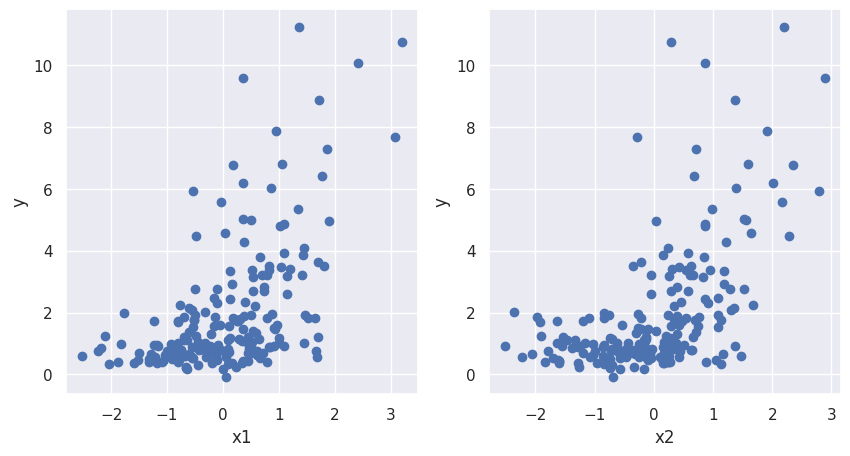

In [86]:
plt.figure(figsize=(10,5));
plt.subplot(1,2,1);
plt.scatter(x_train[:,0],  y_train);
plt.xlabel("x1");
plt.ylabel("y");
plt.subplot(1,2,2);
plt.scatter(x_train[:,1],  y_train);
plt.xlabel("x2");
plt.ylabel("y");

In [87]:
def plot_3D(elev, azim, w0, w1, w2, w3, w4, w5, show_sum, show_basis, show_data, X, y):
    plt.figure(figsize=(10,10))
    ax = plt.subplot(projection='3d')

    X1 = np.arange(-4, 4, 0.2)
    X2 = np.arange(-4, 4, 0.2)
    X1, X2 = np.meshgrid(X1, X2)
    Z0 = w0*np.ones(shape=(X1.shape[0], X2.shape[0]))
    Z1 = w1*X1
    Z2 = w2*X2
    Z3 = w3*X1**2
    Z4 = w4*X2**2
    Z5 = w5*X1*X2

    # Plot the surfaces.
    if show_basis:
      ax.plot_surface(X1, X2, Z0, alpha=0.1, color=sns.color_palette()[1], linewidth=0, antialiased=False)
      ax.plot_surface(X1, X2, Z1, alpha=0.1, color=sns.color_palette()[2], linewidth=0, antialiased=False)
      ax.plot_surface(X1, X2, Z2, alpha=0.1, color=sns.color_palette()[3], linewidth=0, antialiased=False)
      ax.plot_surface(X1, X2, Z3, alpha=0.1, color=sns.color_palette()[4], linewidth=0, antialiased=False)
      ax.plot_surface(X1, X2, Z4, alpha=0.1, color=sns.color_palette()[5], linewidth=0, antialiased=False)
      ax.plot_surface(X1, X2, Z5, alpha=0.1, color=sns.color_palette()[6], linewidth=0, antialiased=False)
    if show_sum:
      ax.plot_surface(X1, X2, (Z0+Z1+Z2+Z3+Z4+Z5), alpha=0.5, color='white', linewidth=0, antialiased=False)
    if show_data:
      ax.scatter3D(X[:, 0], X[:, 1], y, s=50)

    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('y')
    ax.set_zlim(0, 25)
    plt.show()

interact(plot_3D, elev=widgets.IntSlider(min=-90, max=90, step=10, value=20),
          azim=widgets.IntSlider(min=-90, max=90, step=10, value=20),
          w0 = widgets.FloatSlider(min=-1, max=2, step=0.1, value=1),
          w1 = widgets.FloatSlider(min=-1, max=2, step=0.1, value=1),
          w2 = widgets.FloatSlider(min=-1, max=2, step=0.1, value=1),
          w3 = widgets.FloatSlider(min=-1, max=2, step=0.1, value=0.5),
          w4 = widgets.FloatSlider(min=-1, max=2, step=0.1, value=0.5),
          w5 = widgets.FloatSlider(min=-1, max=2, step=0.1, value=1),
         show_sum = False, show_basis = False, show_data = False,
         X=fixed(x_train), y=fixed(y_train));

interactive(children=(IntSlider(value=20, description='elev', max=90, min=-90, step=10), IntSlider(value=20, d…

### Fit a linear regression

In [88]:
reg_lbf = LinearRegression().fit(x_train, y_train)
print("Intercept: " , reg_lbf.intercept_)
print("Coefficient list: ", reg_lbf.coef_)

Intercept:  1.8702634578562658
Coefficient list:  [1.26472771 1.25262881]


### Compute MSE and R2

In [89]:
y_train_hat = reg_lbf.predict(x_train)
print("Training MSE: ", metrics.mean_squared_error(y_train, y_train_hat))
print("Training R2:  ", metrics.r2_score(y_train, y_train_hat))

Training MSE:  1.4458025514450688
Training R2:   0.6647940873954447


### Plot hyperplane

In [90]:
def plot_3D(elev=20, azim=-20, X=x_train, y=y_train):
    plt.figure(figsize=(10,10))
    ax = plt.subplot(projection='3d')


    X1 = np.arange(-4, 4, 0.2)
    X2 = np.arange(-4, 4, 0.2)
    X1, X2 = np.meshgrid(X1, X2)
    Z = X1*reg_lbf.coef_[0] + X2*reg_lbf.coef_[1] + reg_lbf.intercept_

    # Plot the surface.
    ax.plot_surface(X1, X2, Z, alpha=0.1, color='gray',
                          linewidth=0, antialiased=False)
    ax.scatter3D(X[:, 0], X[:, 1], y, s=50)

    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('y')
    plt.show()

interact(plot_3D, elev=widgets.IntSlider(min=-90, max=90, step=10, value=20),
          azim=widgets.IntSlider(min=-90, max=90, step=10, value=20),
         X=fixed(x_train), y=fixed(y_train));

interactive(children=(IntSlider(value=20, description='elev', max=90, min=-90, step=10), IntSlider(value=20, d…

### Residual analysis

In [91]:
residual_train = y_train - y_train_hat

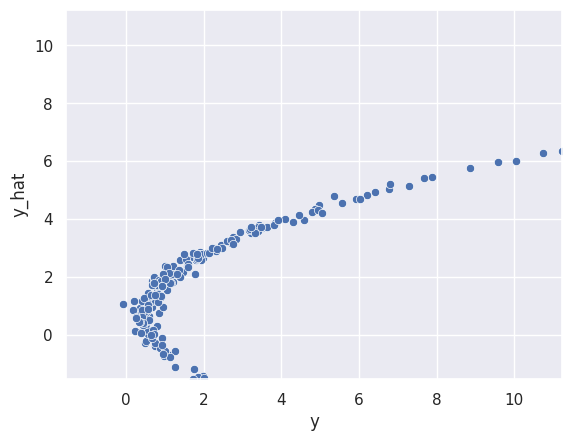

In [92]:
lim_hi = np.max(np.concatenate([y_train, y_train_hat]))
lim_lo = np.min(np.concatenate([y_train, y_train_hat]))
sns.scatterplot(x=y_train, y=y_train_hat);
plt.xlabel('y');
plt.ylabel('y_hat');
plt.xlim(lim_lo, lim_hi);
plt.ylim(lim_lo, lim_hi);

Is the error random? Or does it look systematic?

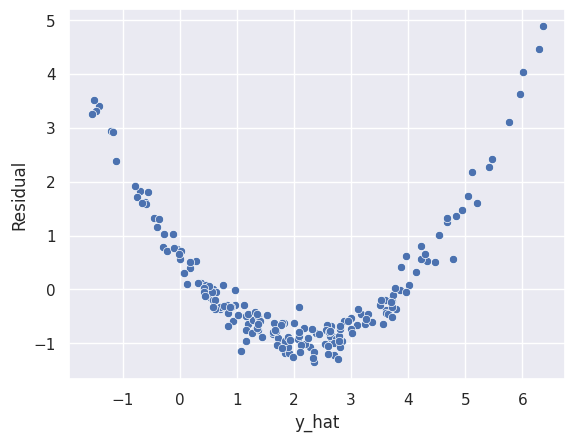

In [93]:
sns.scatterplot(x=y_train_hat, y=residual_train);
plt.xlabel('y_hat');
plt.ylabel('Residual');

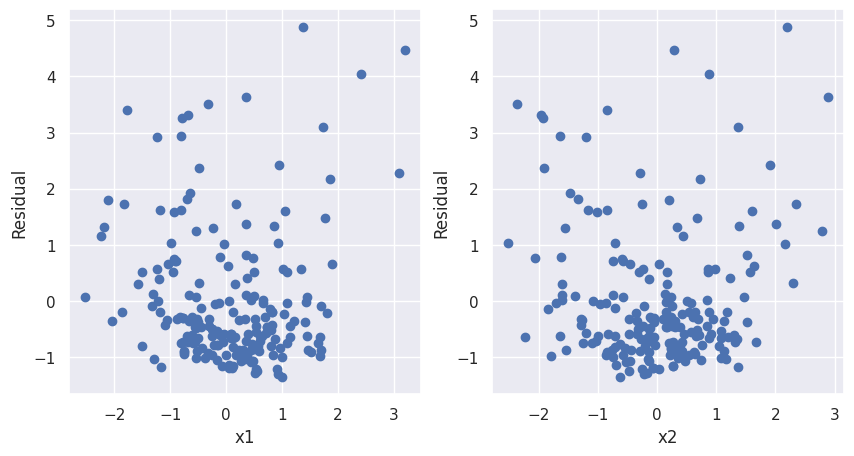

In [94]:
plt.figure(figsize=(10,5));
plt.subplot(1,2,1);
plt.scatter(x_train[:,0],  residual_train);
plt.xlabel("x1");
plt.ylabel("Residual");
plt.subplot(1,2,2);
plt.scatter(x_train[:,1],  residual_train);
plt.xlabel("x2");
plt.ylabel("Residual");

Since there is clearly some non-linearity, we can try to fit a model to a non-linear transformation of the features.

In [95]:
x_train_trans = np.column_stack((x_train, x_train**2))

reg_lbf_trans = LinearRegression().fit(x_train_trans, y_train)
print("Intercept: " , reg_lbf_trans.intercept_)
print("Coefficient list: ", reg_lbf_trans.coef_)

y_train_trans_hat = reg_lbf_trans.predict(x_train_trans)
print("Training MSE: ", metrics.mean_squared_error(y_train, y_train_trans_hat))
print("Training R2:  ", metrics.r2_score(y_train, y_train_trans_hat))

residual_train_trans = y_train - y_train_trans_hat

Intercept:  1.0557889519879486
Coefficient list:  [1.11740182 1.19287037 0.40021922 0.43633874]
Training MSE:  0.7840982673179653
Training R2:   0.8182086654880585


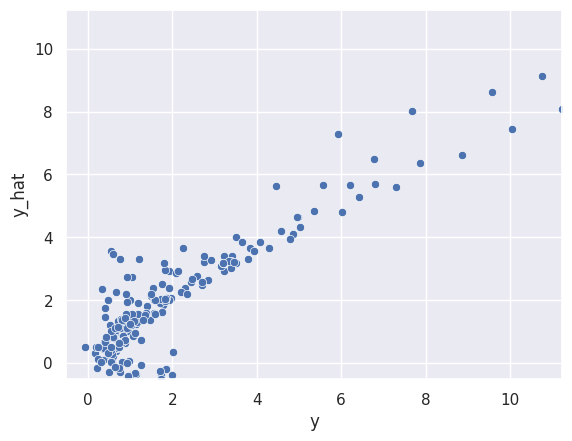

In [96]:
lim_hi = np.max(np.concatenate([y_train, y_train_trans_hat]))
lim_lo = np.min(np.concatenate([y_train, y_train_trans_hat]))
sns.scatterplot(x=y_train, y=y_train_trans_hat);
plt.xlabel('y');
plt.ylabel('y_hat');
plt.xlim(lim_lo, lim_hi);
plt.ylim(lim_lo, lim_hi);

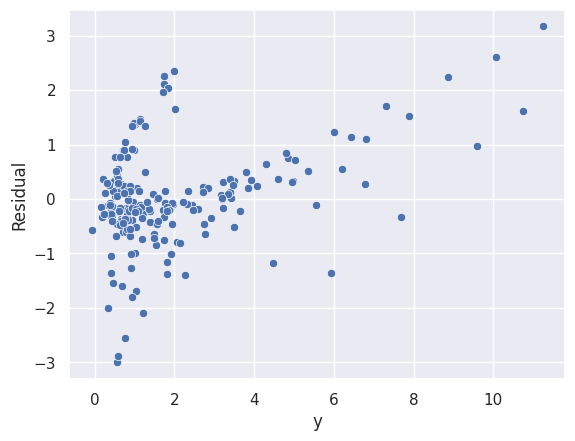

In [97]:
sns.scatterplot(x=y_train, y=residual_train_trans);
plt.xlabel('y');
plt.ylabel('Residual');

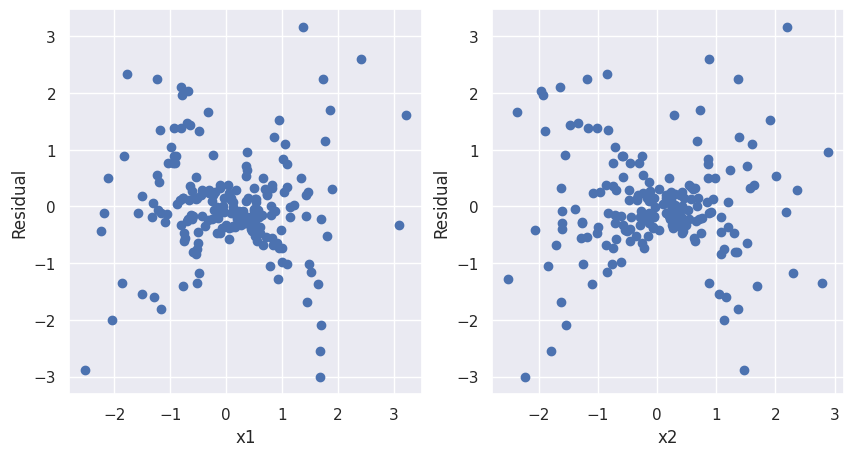

In [98]:
plt.figure(figsize=(10,5));
plt.subplot(1,2,1);
plt.scatter(x_train[:,0],  residual_train_trans);
plt.xlabel("x1");
plt.ylabel("Residual");
plt.subplot(1,2,2);
plt.scatter(x_train[:,1],  residual_train_trans);
plt.xlabel("x2");
plt.ylabel("Residual");

In [99]:
x_train_inter = np.column_stack((x_train_trans, x_train[:,0]*x_train[:,1]))

reg_lbf_inter = LinearRegression().fit(x_train_inter, y_train)
print("Intercept: " , reg_lbf_inter.intercept_)
print("Coefficient list: ", reg_lbf_inter.coef_)

y_train_inter_hat = reg_lbf_inter.predict(x_train_inter)
print("Training MSE: ", metrics.mean_squared_error(y_train, y_train_inter_hat))
print("Training R2:  ", metrics.r2_score(y_train, y_train_inter_hat))

residual_train_inter = y_train - y_train_inter_hat

Intercept:  0.9476293608541282
Coefficient list:  [0.99385399 1.01535476 0.51757429 0.51894949 1.01076238]
Training MSE:  0.03747972911770794
Training R2:   0.991310413174665


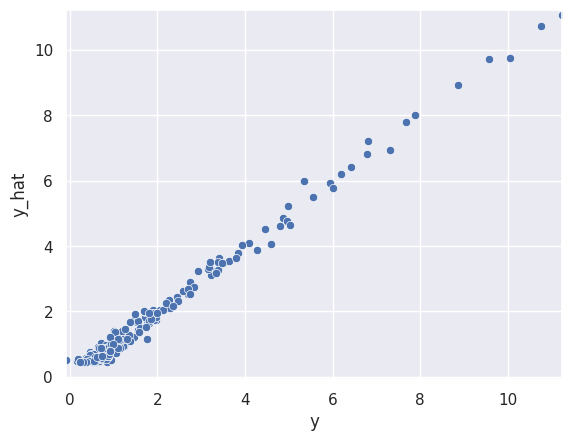

In [100]:
lim_hi = np.max(np.concatenate([y_train, y_train_inter_hat]))
lim_lo = np.min(np.concatenate([y_train, y_train_inter_hat]))
sns.scatterplot(x=y_train, y=y_train_inter_hat);
plt.xlabel('y');
plt.ylabel('y_hat');
plt.xlim(lim_lo, lim_hi);
plt.ylim(lim_lo, lim_hi);

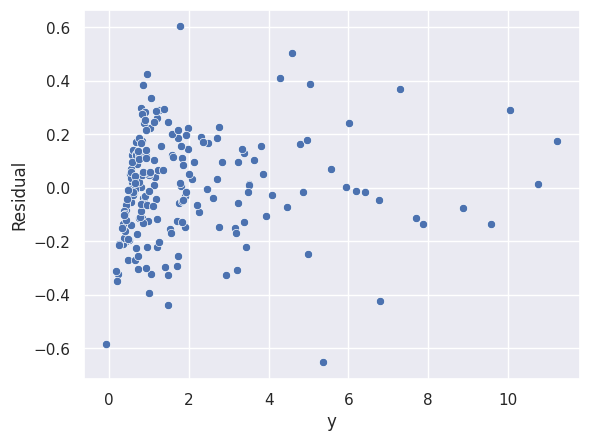

In [101]:
sns.scatterplot(x=y_train, y=residual_train_inter);
plt.xlabel('y');
plt.ylabel('Residual');

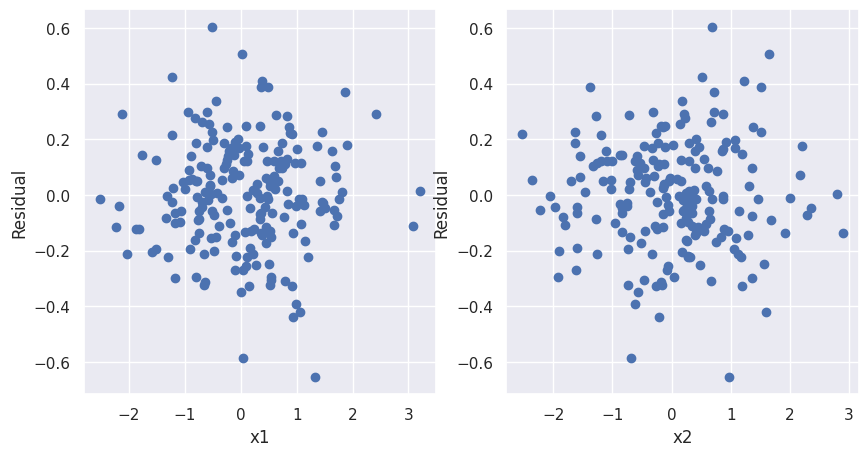

In [102]:
plt.figure(figsize=(10,5));
plt.subplot(1,2,1);
plt.scatter(x_train[:,0],  residual_train_inter);
plt.xlabel("x1");
plt.ylabel("Residual");
plt.subplot(1,2,2);
plt.scatter(x_train[:,1],  residual_train_inter);
plt.xlabel("x2");
plt.ylabel("Residual");

### Evaluate on test set

In [103]:
y_train_hat = reg_lbf_inter.predict(x_train_inter)
print("Training MSE: ", metrics.mean_squared_error(y_train, y_train_hat))
print("Training R2:  ", metrics.r2_score(y_train, y_train_hat))

Training MSE:  0.03747972911770794
Training R2:   0.991310413174665


In [104]:
x_test_inter = np.column_stack((x_test, x_test**2))
x_test_inter = np.column_stack((x_test_inter, x_test[:,0]*x_test[:,1]))

y_test_hat = reg_lbf_inter.predict(x_test_inter)
print("Test MSE: ", metrics.mean_squared_error(y_test, y_test_hat))
print("Test R2:  ", metrics.r2_score(y_test, y_test_hat))

Test MSE:  0.05673851845590067
Test R2:   0.9868347131068158
